# Rotated Labeled Wafer Images

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

## Rotated [90 degrees] Silicon Wafer 1

### Load Data

In [3]:
# reminder: image is downscaled by 3, we need to downscale the labels' coordinates as well
scale = 3

In [4]:
# location of silicon wafer 1 data
dir_silicon_wafer_1 = "../dataset/silicon_wafer_1"

Prepare column names (`MultiIndex`) for reading data frame:

In [5]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

Read the labels of tissue from the file:

In [6]:
wafer_tissue_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_tissue.txt", sep="\t|,", header=None, names=index, engine='python')//scale
print(f"Size of the Silicon Wafer 1 dataset, tissue part is {wafer_tissue_lbl.shape}")
wafer_tissue_lbl.head()

Size of the Silicon Wafer 1 dataset, tissue part is (514, 8)


point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    2261  1031    2241   979    2367   937    2373   988
1    2115  1072    2091  1022    2216   974    2225  1023
2    2012  1198    1990  1147    2117  1104    2123  1154
3    2162  1201    2133  1153    2249  1091    2264  1141
4    2286  1169    2258  1121    2378  1062    2390  1111

Read the labels of magnet from the file:

In [7]:
wafer_magnet_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_mag.txt", sep="\t|,", header=None, names=index, engine='python')//scale
print(f"Size of the Silicon Wafer 1 dataset, magnet part is {wafer_magnet_lbl.shape}")
wafer_magnet_lbl.head()

Size of the Silicon Wafer 1 dataset, magnet part is (514, 8)


point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    2280  1077    2262  1033    2373   989    2381  1039
1    2136  1118    2117  1075    2224  1025    2235  1072
2    2032  1244    2013  1199    2124  1155    2132  1203
3    2188  1246    2163  1203    2263  1141    2280  1188
4    2310  1212    2286  1170    2390  1112    2404  1159

### Drawing

Helper to convert hex color code to RGB code.

In [8]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

Helper to draw labels from dataframe on the image:

In [9]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

Read the image of Silicon Wafer 1:

In [10]:
wafer_1 = cv.imread(f"{dir_silicon_wafer_1}/wafer_1_downsize_3.tif")

Some general settings:

In [11]:
scale = 3
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

### Rotate the image

In [12]:
# number of pixels: rows, cols = 5616, 6136
rows, cols = wafer_1.shape[:2]

# center of rotation (x, y)
center = (cols/2, rows/2)

# angle of couterclockwise rotation
angle = 90

# get rotation matrix, will be used in labels rotation
M = cv.getRotationMatrix2D(center, angle=angle, scale=1)
print(f"Rotation martix: \n{M}")

# rotate the picture
wafer_1_rot = cv.warpAffine(wafer_1, M, wafer_1.shape[:2])

Rotation martix: 
[[ 6.123234e-17  1.000000e+00  2.600000e+02]
 [-1.000000e+00  6.123234e-17  5.876000e+03]]


### Rotate the labels

In [13]:
wafer_tissue_lbl_rot = wafer_tissue_lbl.apply(lambda row: row.groupby(level=0).apply(lambda col: pd.Series(np.dot(M, np.array([*col, 1]).T), index=col.index, dtype=int)), axis=1)
wafer_magnet_lbl_rot = wafer_magnet_lbl.apply(lambda row: row.groupby(level=0).apply(lambda col: pd.Series(np.dot(M, np.array([*col, 1]).T), index=col.index, dtype=int)), axis=1)

### Drawing

In [14]:
wafer_1_rot = draw_labels(wafer_1_rot, wafer_tissue_lbl_rot, thickness, tissue_color, fill_poly)

In [15]:
wafer_1_rot = draw_labels(wafer_1_rot, wafer_magnet_lbl_rot, thickness, magnet_color, fill_poly)

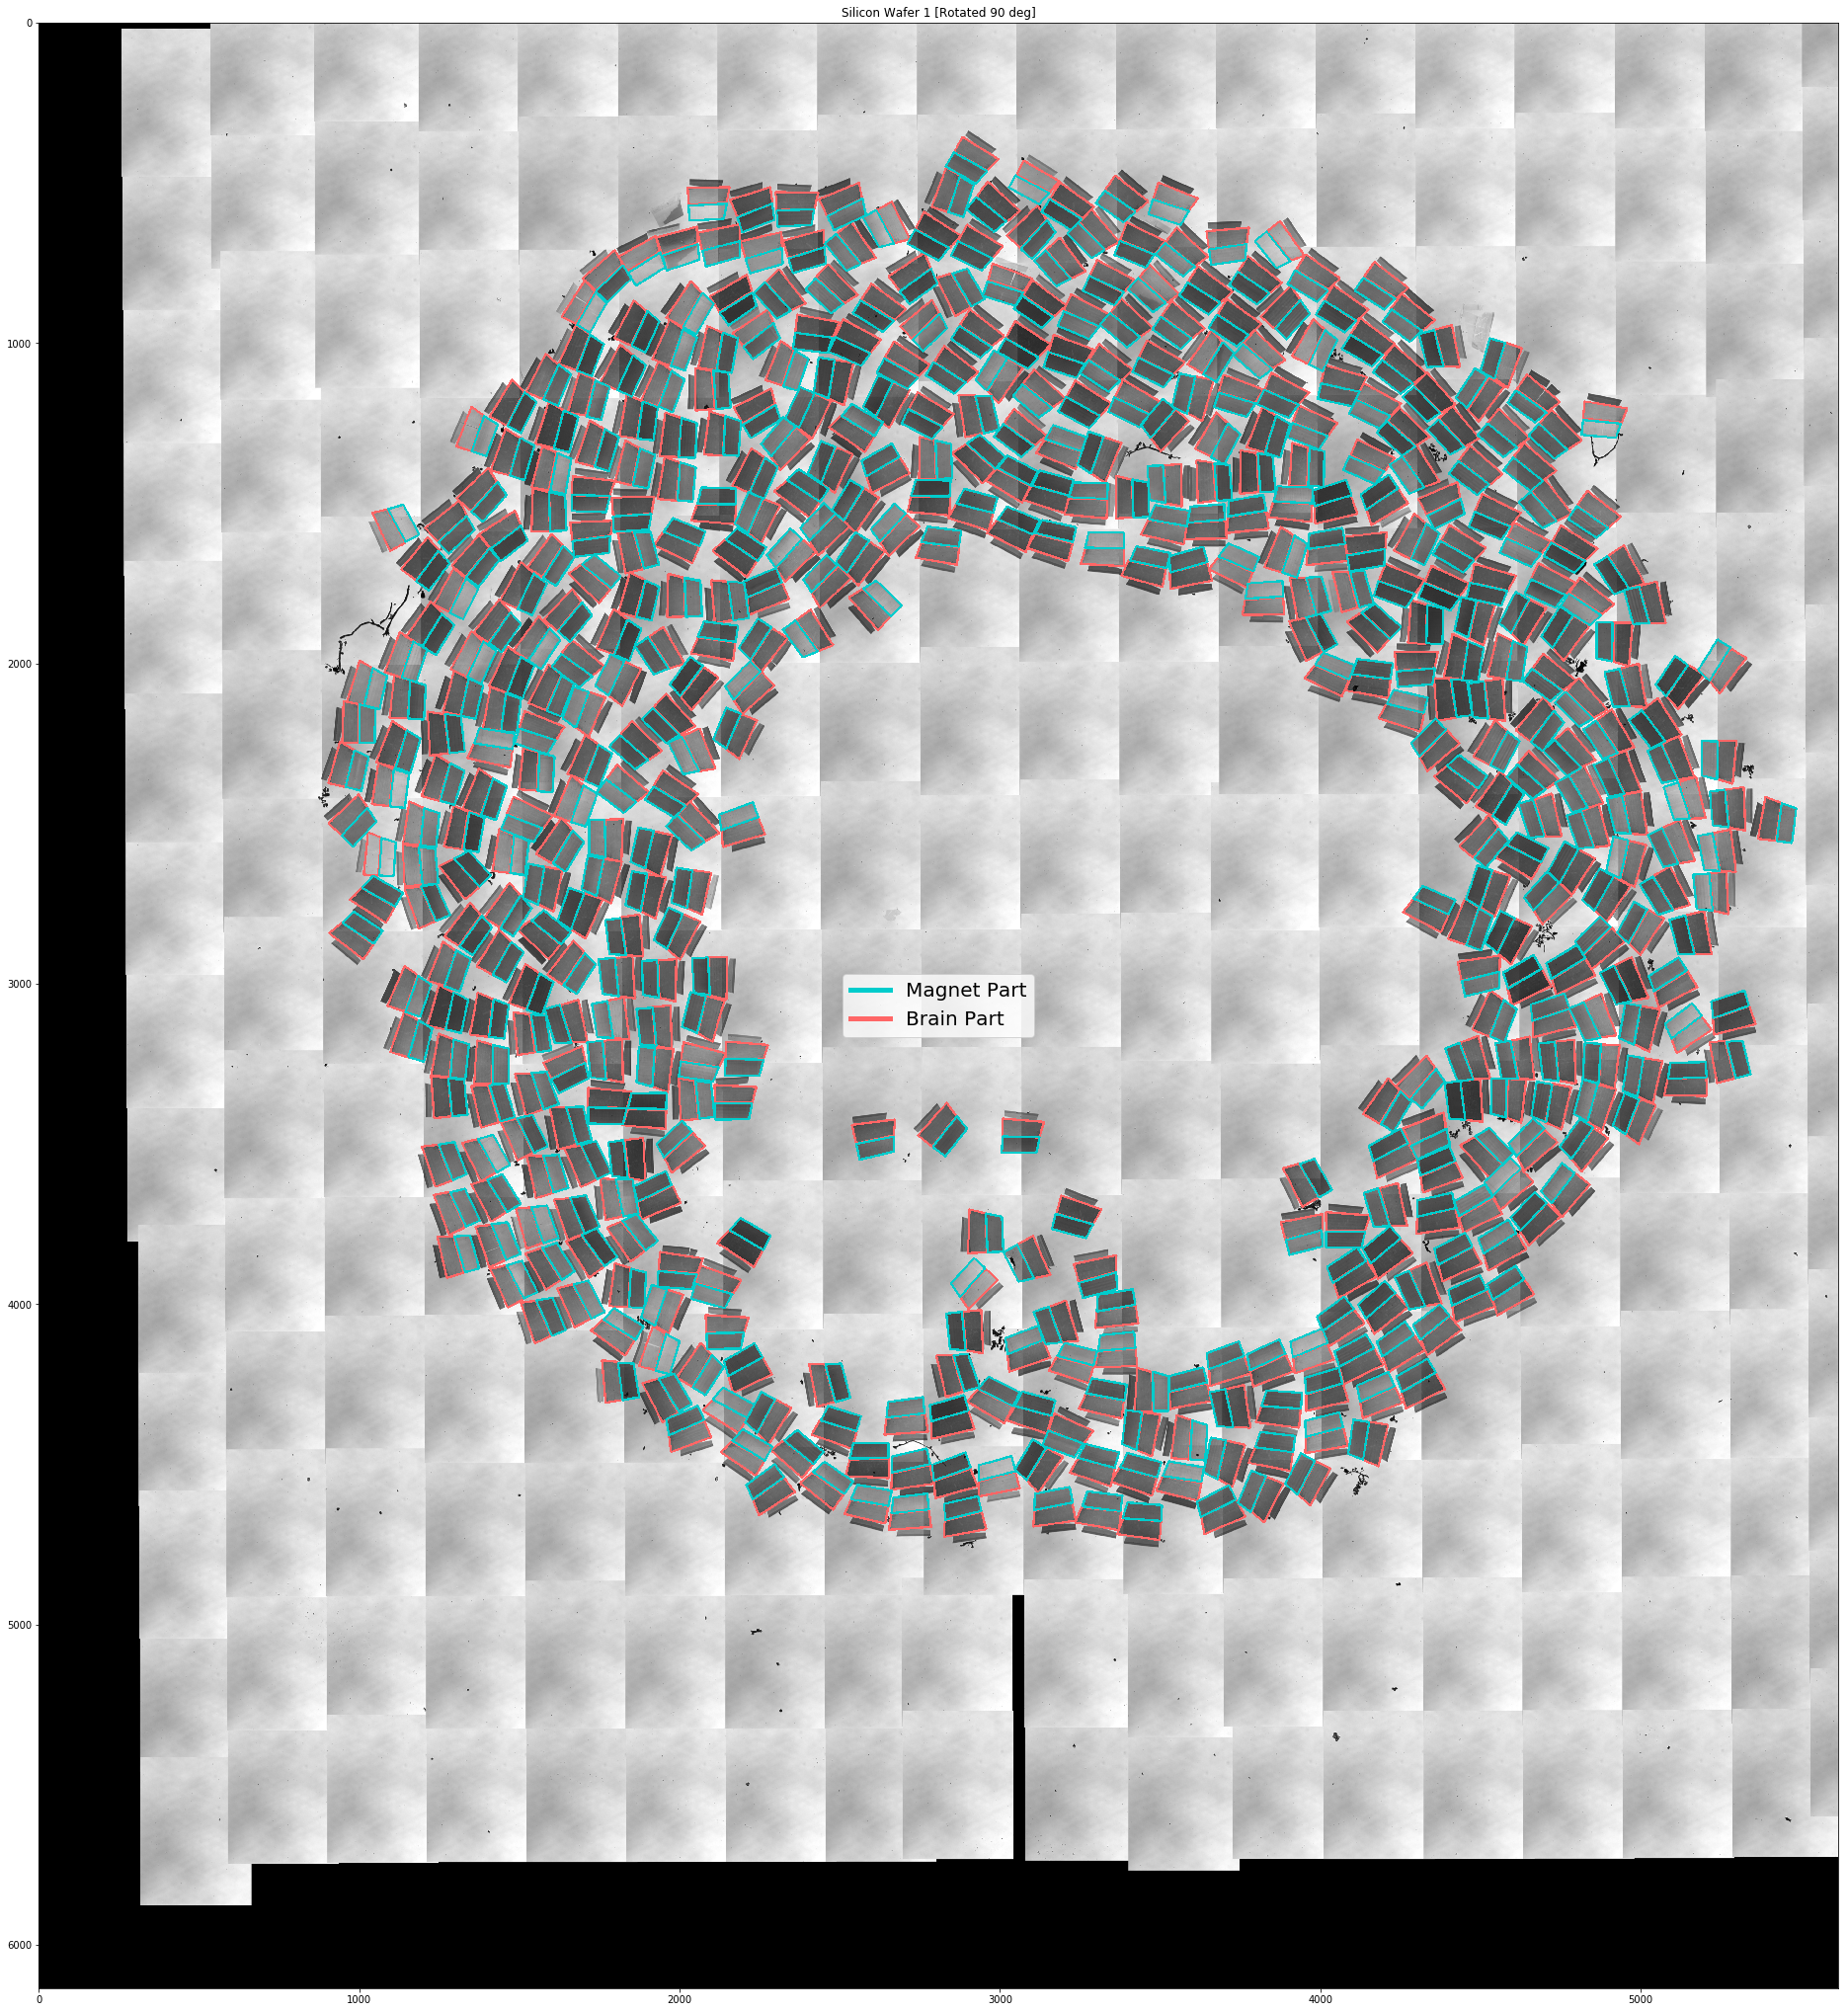

In [16]:
plt.figure(figsize=(40, 36.61))
plt.imshow(wafer_1_rot)
plt.title('Silicon Wafer 1 [Rotated 90 deg]')

legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                   Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]
plt.legend(handles=legend_elements, loc='center', fontsize=20)

plt.show()